# Estimation of obesity levels based on eating habits and physical condition (Base 1)

O uso dessa base permite-nos classificar o nível de obesidade de uma pessoa com base em suas condições físicas, hábitos alimentares e características.

Em virtude dessa base possuir muitos atributos, comecemos então em mostrar o dicionário de dados.


## Dicionário de dados

#### Hábitos alimentares

- FAVC: Consumo frequente de alimentos altamente calóricos
- FCVC: Frequência do consumo de vegetais
- NCP: Número de refeições principais
- CAEC: Consumo de comda entre refeições
- CH2O: Consumo diário de água
- CALC: Consumo de álcohol

#### Condições físicas

- SCC: Monitoramento do consumo de calorias
- FAF: Frequência de atividades físicas
- TUE: Tempo utilizando dispositivos de tecnologia
- MTRANS: Meio de transporte utilizado

#### Características físicas

- Gênero
- Idade
- Altura
- Peso

### Target

- Peso insuficiente
- Peso normal
- Excesso de peso nível 1
- Excesso de peso nível 2
- Obesidade tipo I
- Obesidade tipo II
- Obesidade tipo III




In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from scipy.stats import zscore

Comecemos por ler o arquivo pelo link no github

In [181]:
url = 'https://raw.githubusercontent.com/mochaeng/Intelligent-Systems/main/projects/exer-3/obesity/data/ObesityDataSet_raw_and_data_sinthetic.csv'
base_raw = pd.read_csv(url)

base_df = pd.DataFrame(base_raw)
base_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Visão geral da base

- É possível ver a média, desvio padrão dos valores das colunas de valores númericos
- Não há nenhum valor ausente
- A base possui 24 linhas duplicadas

In [182]:
base_df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [183]:
base_df.duplicated().sum()

24

In [184]:
base_df.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

# Tratamento à priori da base

- A coluna **NObeyesdad** será renomeada para **Target**
- Remoção dos valores duplicados. Comente essa linha se desejares considerá-los
- Criação da coluna com cálculo do IMC com base nas


In [185]:
base_df.rename({'NObeyesdad': 'target'}, axis=1, inplace=True)

In [186]:
# base_df = base_df.loc[~base_df.duplicated()]

In [187]:
base_df['mbi'] = base_df['Weight'] / (base_df['Height'] ** 2)
base_df['mbi']

0       24.386526
1       24.238227
2       23.765432
3       26.851852
4       28.342381
          ...    
2106    44.901475
2107    43.741923
2108    43.543817
2109    44.071535
2110    44.144338
Name: mbi, Length: 2111, dtype: float64

# Normalização categórica da base

Os três métodos de normalização categórica foram utilizados

- Nominal Encoding: **MTRANS**. Uma vez que não existe uma forma de estabelecermos ordem entre os valores
- Ordinal Encoding: **CAEC** e **CALC**. Podemos estabelecer uma ordem entre os valores: _no_, _Sometimes_, _Frequently_, _Always_
- Label Encoding: **Gender**, **family_history_with_overweight**, **FAVC**, **SMOKE**, **SCC**. Já que os valores são coisas como _masculino_, _feminino_ e _yes_, _no_, label encoding é o que melhor se encaixa.

Após a normalização cetegórica, o _dataframe_ ficará na variável: **obesity_df**


In [188]:
## Nominal (One Hot Encoding)
nominal_columns = ['MTRANS']
obesity_df = pd.get_dummies(base_df, prefix=nominal_columns, columns=nominal_columns, dtype=int)
nominal_columns_names = obesity_df.columns.to_list()

## Ordinal (Ordinal Encoding)
ordinal_columns = ['CAEC', 'CALC']
caec_options = ['no', 'Sometimes', 'Frequently', 'Always']
calc_options = ['no', 'Sometimes', 'Frequently', 'Always']
ordinal_encode = OrdinalEncoder(categories=[caec_options, calc_options])
obesity_df[ordinal_columns] = ordinal_encode.fit_transform(obesity_df[ordinal_columns])

## Label (Label Encoding)
label_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
label_encode = OrdinalEncoder()
obesity_df[label_columns] = label_encode.fit_transform(obesity_df[label_columns])

obesity_df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,target,mbi,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,21.000000,1.620000,64.000000,1.0,0.0,2.0,3.0,1.0,0.0,...,0.000000,1.000000,0.0,Normal_Weight,24.386526,0,0,0,1,0
1,0.0,21.000000,1.520000,56.000000,1.0,0.0,3.0,3.0,1.0,1.0,...,3.000000,0.000000,1.0,Normal_Weight,24.238227,0,0,0,1,0
2,1.0,23.000000,1.800000,77.000000,1.0,0.0,2.0,3.0,1.0,0.0,...,2.000000,1.000000,2.0,Normal_Weight,23.765432,0,0,0,1,0
3,1.0,27.000000,1.800000,87.000000,0.0,0.0,3.0,3.0,1.0,0.0,...,2.000000,0.000000,2.0,Overweight_Level_I,26.851852,0,0,0,0,1
4,1.0,22.000000,1.780000,89.800000,0.0,0.0,2.0,1.0,1.0,0.0,...,0.000000,0.000000,1.0,Overweight_Level_II,28.342381,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,20.976842,1.710730,131.408528,1.0,1.0,3.0,3.0,1.0,0.0,...,1.676269,0.906247,1.0,Obesity_Type_III,44.901475,0,0,0,1,0
2107,0.0,21.982942,1.748584,133.742943,1.0,1.0,3.0,3.0,1.0,0.0,...,1.341390,0.599270,1.0,Obesity_Type_III,43.741923,0,0,0,1,0
2108,0.0,22.524036,1.752206,133.689352,1.0,1.0,3.0,3.0,1.0,0.0,...,1.414209,0.646288,1.0,Obesity_Type_III,43.543817,0,0,0,1,0
2109,0.0,24.361936,1.739450,133.346641,1.0,1.0,3.0,3.0,1.0,0.0,...,1.139107,0.586035,1.0,Obesity_Type_III,44.071535,0,0,0,1,0


# Obordagens para remoção de colunas

Como especificado no slide, várias abordagens para dropar colunas foram utilizadas.

Basta apenas descomentar a linha que desejares testar

In [189]:
# ABORDAGEM 1
# X = obesity_df.drop(columns=['target', 'mbi'], axis=1)

# ABORDAGEM 2
# X = obesity_df.drop(columns=['target'], axis=1)

# ABORDAGEM 3
X = obesity_df.drop(columns=['target', 'Gender','Age', 'Height', 'Weight'], axis=1)

# ABORDAGEM 4
#X = obesity_df.drop(columns=['target', 'Gender','Age', 'Height', 'Weight', 'SCC', 'FAF', 'TUE', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation' , 'MTRANS_Walking'], axis=1)

# ABORDAGEM 5
# X = obesity_df.drop(columns=['target', 'Gender','Age', 'Height', 'Weight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'CALC'], axis=1)

y = base_df['target']


# Normalização (Min-Max, Zscore)

A seguir são feitos as normalizações com Min-Max, Z-score e sem normalizar



In [190]:
X_min_max = MinMaxScaler().fit_transform(X)
X_not_norm = X.to_numpy()
X_zscore = zscore(X).to_numpy()

# Treinamento

Já que há três tipos de dataframes (min-max, zscore, não-normalizado), uma função simples foi criada para realizar o _split_ e treinamento da base. A função retorna em um dataframe de duas colunas: o valor de k e a acurácia.

Basta a pena descomentar a linha que você deseja utlizar como dataframe

In [191]:
def split_and_train(x_array):
    X_train, X_test, y_train, y_test = train_test_split(x_array, y, test_size=0.3, random_state=57)

    results = []
    for i in range(1, 13):
        knn_obesity = KNeighborsClassifier(n_neighbors=i)
        knn_obesity.fit(X_train, y_train)
        results.append(
            [i, accuracy_score(y_test, knn_obesity.predict(X_test))]
        )

    accuracy_df = pd.DataFrame(results, columns=['K', 'Accuracy'])

    return accuracy_df

In [192]:
split_and_train(X_not_norm)
#split_and_train(X_min_max)
#split_and_train(X_zscore)

,K,Accuracy
0,1,0.970032
1,2,0.957413
2,3,0.965300
3,4,0.955836
4,5,0.962145
5,6,0.955836
6,7,0.954259
7,8,0.952681
8,9,0.952681
9,10,0.952681


# GRAFICOS: NÃO *NORMALIZADA*

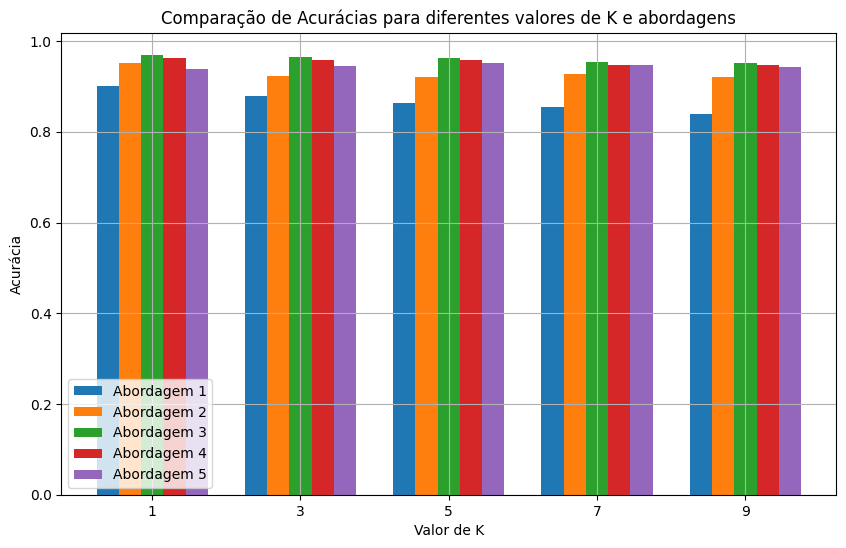

In [193]:
import numpy as np

valores_k = [1, 3, 5, 7, 9]
#NAO NORMALIZADA
abordagem1= [0.900631, 0.880126, 0.862776, 0.854890, 0.839117]
abordagem2= [0.951104, 0.922713, 0.921136, 0.927445, 0.921136]
abordagem3= [0.970032, 0.965300, 0.962145, 0.954259, 0.952681]
abordagem4= [0.963722, 0.958991, 0.957413, 0.947950, 0.947950]
abordagem5= [0.938486, 0.944795, 0.951104, 0.946372, 0.943218]

#BARRAS AGRUPADAS
bar_width = 0.15
index = np.arange(len(valores_k))
plt.figure(figsize=(10, 6))
plt.bar(index, abordagem1, bar_width, label="Abordagem 1")
plt.bar(index + bar_width, abordagem2, bar_width, label="Abordagem 2")
plt.bar(index + 2*bar_width, abordagem3, bar_width, label="Abordagem 3")
plt.bar(index + 3*bar_width, abordagem4, bar_width, label="Abordagem 4")
plt.bar(index + 4*bar_width, abordagem5, bar_width, label="Abordagem 5")
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens')

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens')
plt.xticks(index + 2*bar_width, valores_k)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()



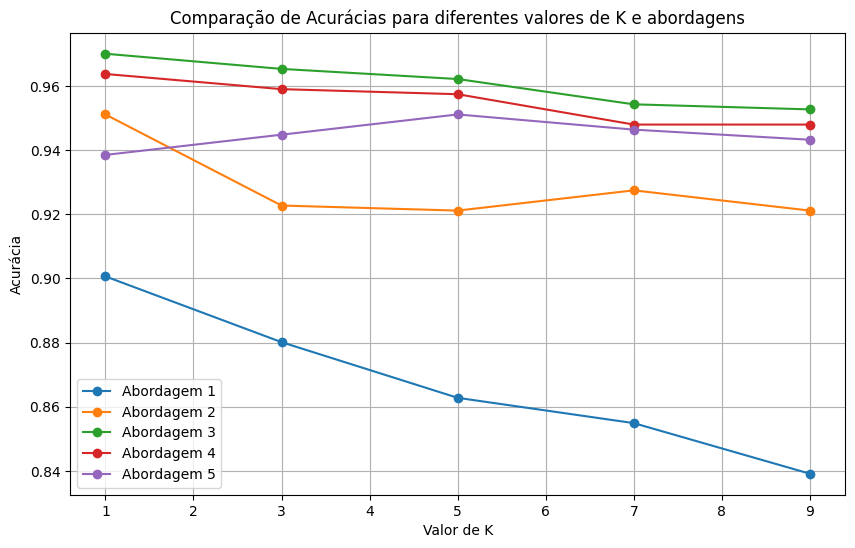

In [194]:
plt.figure(figsize=(10, 6))

abordagem1 = [0.900631, 0.880126, 0.862776, 0.854890, 0.839117]
abordagem2 = [0.951104, 0.922713, 0.921136, 0.927445, 0.921136]
abordagem3 = [0.970032, 0.965300, 0.962145, 0.954259, 0.952681]
abordagem4 = [0.963722, 0.958991, 0.957413, 0.947950, 0.947950]
abordagem5 = [0.938486, 0.944795, 0.951104, 0.946372, 0.943218]

#LINHAS
plt.plot(valores_k, abordagem1, label="Abordagem 1", marker='o')
plt.plot(valores_k, abordagem2, label="Abordagem 2", marker='o')
plt.plot(valores_k, abordagem3, label="Abordagem 3", marker='o')
plt.plot(valores_k, abordagem4, label="Abordagem 4", marker='o')
plt.plot(valores_k, abordagem5, label="Abordagem 5", marker='o')

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens')
plt.legend()
plt.grid(True)
plt.show()

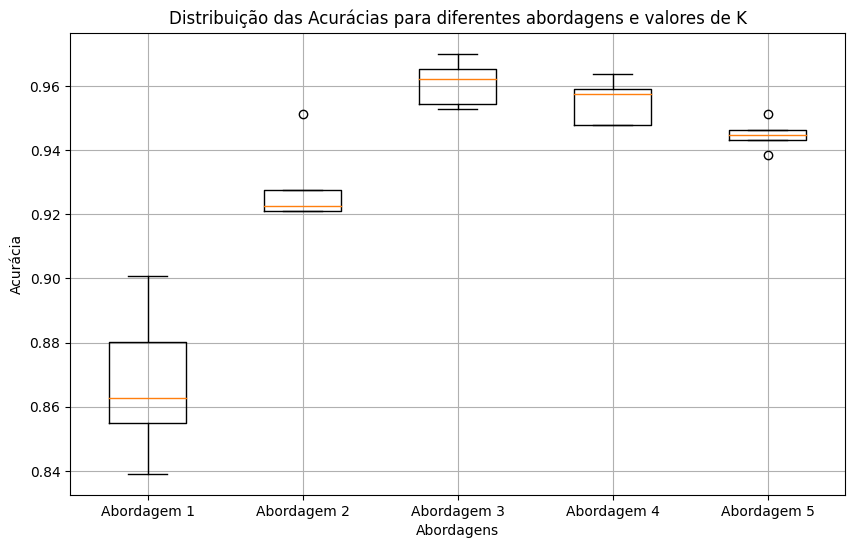

In [195]:
import matplotlib.pyplot as plt

#BOXPLOT
valores_k = [1, 3, 5, 7, 9]
abordagem1 = [0.900631, 0.880126, 0.862776, 0.854890, 0.839117]
abordagem2 = [0.951104, 0.922713, 0.921136, 0.927445, 0.921136]
abordagem3 = [0.970032, 0.965300, 0.962145, 0.954259, 0.952681]
abordagem4 = [0.963722, 0.958991, 0.957413, 0.947950, 0.947950]
abordagem5 = [0.938486, 0.944795, 0.951104, 0.946372, 0.943218]

plt.figure(figsize=(10, 6))

# Criando o boxplot para cada abordagem
plt.boxplot([abordagem1, abordagem2, abordagem3, abordagem4, abordagem5],
            labels=['Abordagem 1', 'Abordagem 2', 'Abordagem 3', 'Abordagem 4', 'Abordagem 5'])

plt.xlabel('Abordagens')
plt.ylabel('Acurácia')
plt.title('Distribuição das Acurácias para diferentes abordagens e valores de K')
plt.grid(True)
plt.show()


# GRAFICOS: NORMALIZADA POR MINMAX

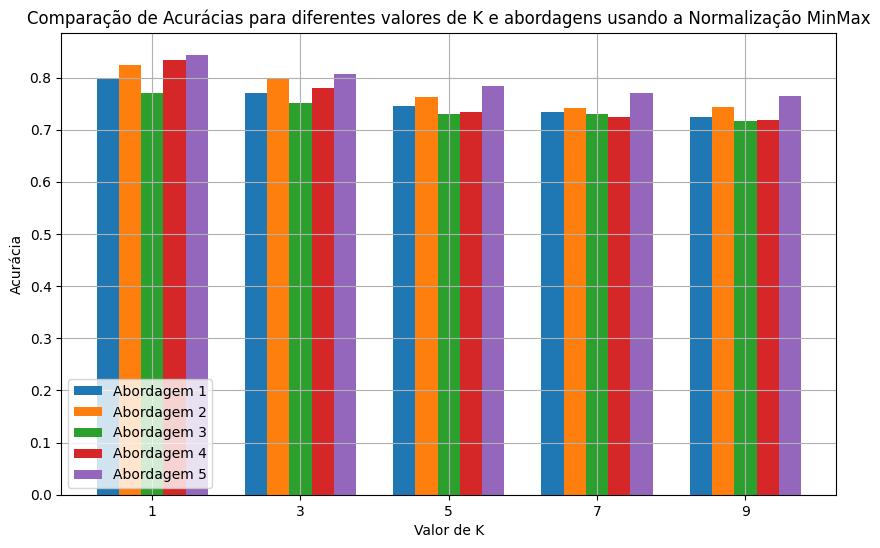

In [196]:
valores_k = [1, 3, 5, 7, 9]
#MINMAX
abordagem1= [0.796530, 0.769716, 0.746057, 0.733438, 0.723975]
abordagem2= [0.823344, 0.798107, 0.763407, 0.741325, 0.744479]
abordagem3= [0.771293, 0.750789, 0.730284, 0.730284, 0.717666]
abordagem4= [0.832808, 0.779180, 0.733438, 0.723975, 0.719243]
abordagem5= [0.843849, 0.805994, 0.783912, 0.769716, 0.764984]

#BARRAS AGRUPADAS
bar_width = 0.15
index = np.arange(len(valores_k))
plt.figure(figsize=(10, 6))
plt.bar(index, abordagem1, bar_width, label="Abordagem 1")
plt.bar(index + bar_width, abordagem2, bar_width, label="Abordagem 2")
plt.bar(index + 2*bar_width, abordagem3, bar_width, label="Abordagem 3")
plt.bar(index + 3*bar_width, abordagem4, bar_width, label="Abordagem 4")
plt.bar(index + 4*bar_width, abordagem5, bar_width, label="Abordagem 5")
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens')

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens usando a Normalização MinMax')
plt.xticks(index + 2*bar_width, valores_k)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

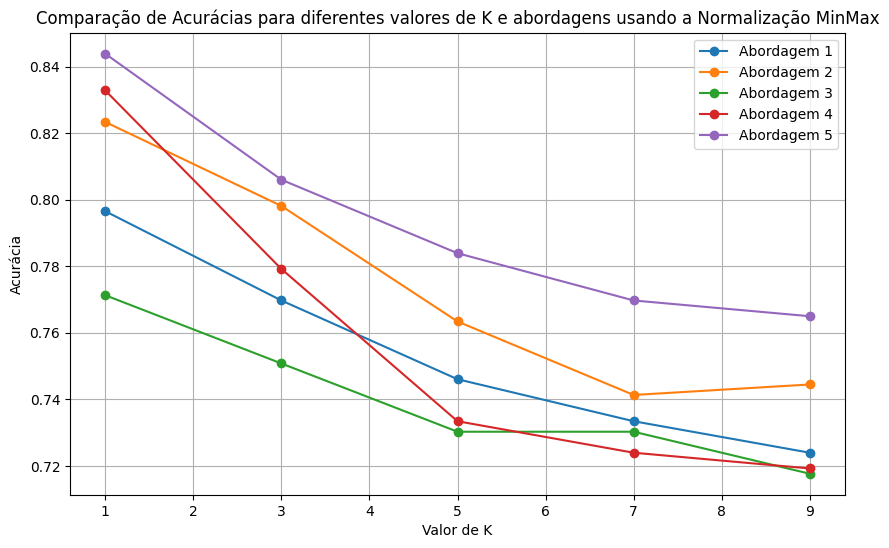

In [197]:
plt.figure(figsize=(10, 6))

abordagem1= [0.796530, 0.769716, 0.746057, 0.733438, 0.723975]
abordagem2= [0.823344, 0.798107, 0.763407, 0.741325, 0.744479]
abordagem3= [0.771293, 0.750789, 0.730284, 0.730284, 0.717666]
abordagem4= [0.832808, 0.779180, 0.733438, 0.723975, 0.719243]
abordagem5= [0.843849, 0.805994, 0.783912, 0.769716, 0.764984]

#LINHAS
plt.plot(valores_k, abordagem1, label="Abordagem 1", marker='o')
plt.plot(valores_k, abordagem2, label="Abordagem 2", marker='o')
plt.plot(valores_k, abordagem3, label="Abordagem 3", marker='o')
plt.plot(valores_k, abordagem4, label="Abordagem 4", marker='o')
plt.plot(valores_k, abordagem5, label="Abordagem 5", marker='o')

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens usando a Normalização MinMax')
plt.legend()
plt.grid(True)
plt.show()

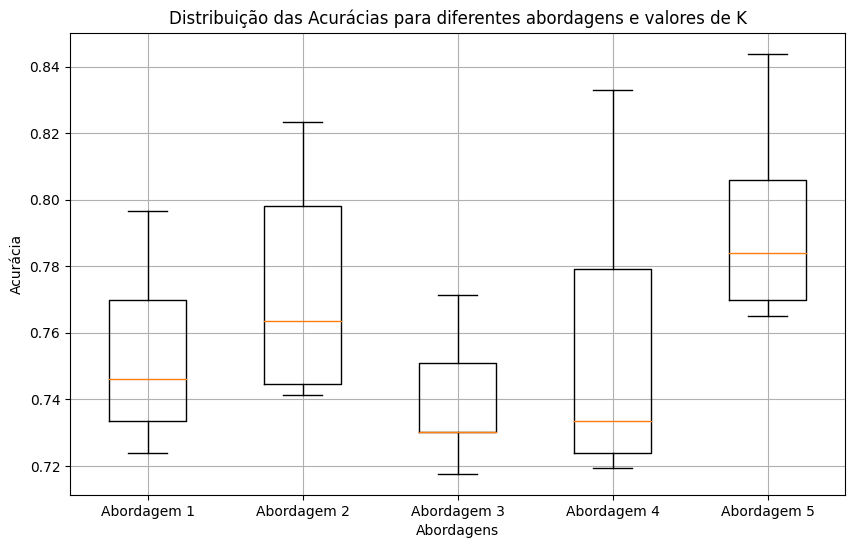

In [198]:
import matplotlib.pyplot as plt

#BOXPLOT
valores_k = [1, 3, 5, 7, 9]
abordagem1= [0.796530, 0.769716, 0.746057, 0.733438, 0.723975]
abordagem2= [0.823344, 0.798107, 0.763407, 0.741325, 0.744479]
abordagem3= [0.771293, 0.750789, 0.730284, 0.730284, 0.717666]
abordagem4= [0.832808, 0.779180, 0.733438, 0.723975, 0.719243]
abordagem5= [0.843849, 0.805994, 0.783912, 0.769716, 0.764984]

plt.figure(figsize=(10, 6))

# Criando o boxplot para cada abordagem
plt.boxplot([abordagem1, abordagem2, abordagem3, abordagem4, abordagem5],
            labels=['Abordagem 1', 'Abordagem 2', 'Abordagem 3', 'Abordagem 4', 'Abordagem 5'])

plt.xlabel('Abordagens')
plt.ylabel('Acurácia')
plt.title('Distribuição das Acurácias para diferentes abordagens e valores de K')
plt.grid(True)
plt.show()


# GRAFICOS: NORMALIZADA POR Z-SCORE

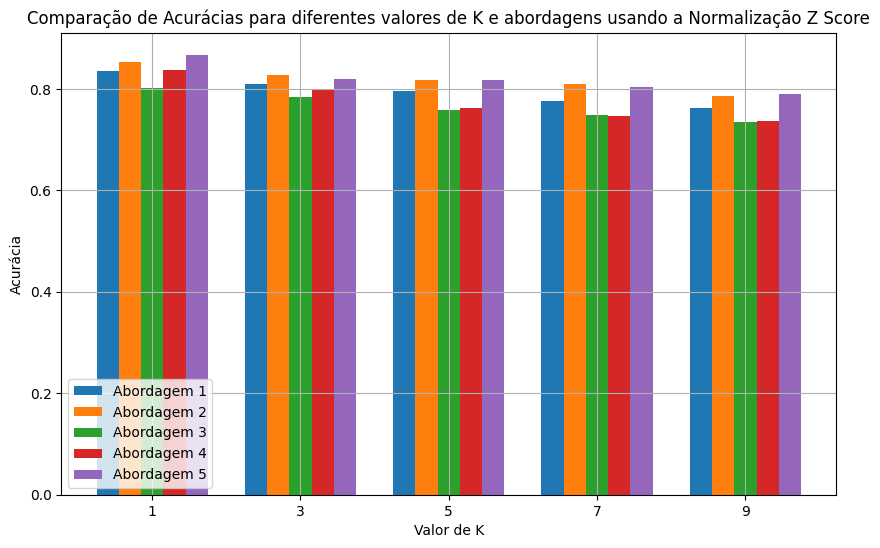

In [199]:
valores_k = [1, 3, 5, 7, 9]
#Z SCORE
abordagem1= [0.835962, 0.810726, 0.796530, 0.776025, 0.763407]
abordagem2= [0.853312, 0.828076, 0.818612, 0.809148, 0.787066]
abordagem3= [0.802839, 0.783912, 0.758675, 0.749211, 0.735016]
abordagem4= [0.837539, 0.799685, 0.761830, 0.746057, 0.736593]
abordagem5= [0.867508, 0.820189, 0.818612, 0.804416, 0.790221]

#BARRAS AGRUPADAS
bar_width = 0.15
index = np.arange(len(valores_k))
plt.figure(figsize=(10, 6))
plt.bar(index, abordagem1, bar_width, label="Abordagem 1")
plt.bar(index + bar_width, abordagem2, bar_width, label="Abordagem 2")
plt.bar(index + 2*bar_width, abordagem3, bar_width, label="Abordagem 3")
plt.bar(index + 3*bar_width, abordagem4, bar_width, label="Abordagem 4")
plt.bar(index + 4*bar_width, abordagem5, bar_width, label="Abordagem 5")
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens')

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens usando a Normalização Z Score')
plt.xticks(index + 2*bar_width, valores_k)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

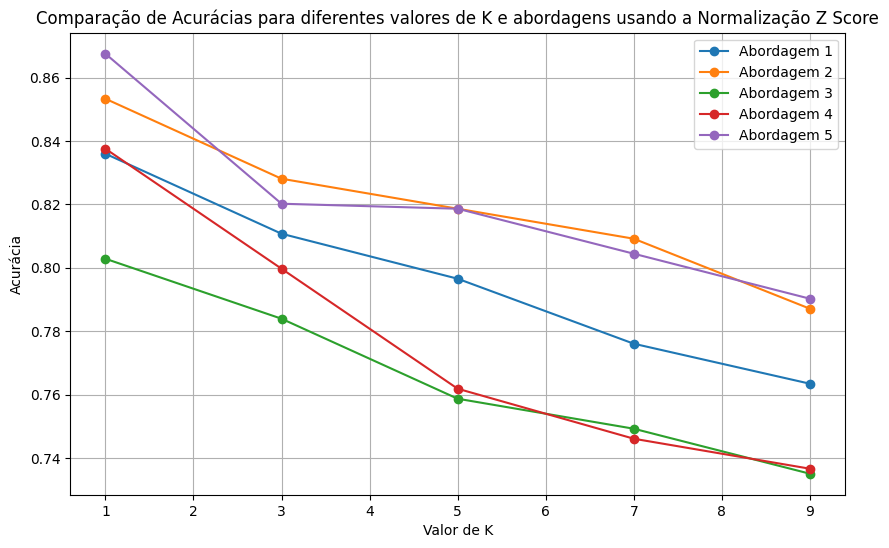

In [200]:
plt.figure(figsize=(10, 6))

abordagem1= [0.835962, 0.810726, 0.796530, 0.776025, 0.763407]
abordagem2= [0.853312, 0.828076, 0.818612, 0.809148, 0.787066]
abordagem3= [0.802839, 0.783912, 0.758675, 0.749211, 0.735016]
abordagem4= [0.837539, 0.799685, 0.761830, 0.746057, 0.736593]
abordagem5= [0.867508, 0.820189, 0.818612, 0.804416, 0.790221]

#LINHAS
plt.plot(valores_k, abordagem1, label="Abordagem 1", marker='o')
plt.plot(valores_k, abordagem2, label="Abordagem 2", marker='o')
plt.plot(valores_k, abordagem3, label="Abordagem 3", marker='o')
plt.plot(valores_k, abordagem4, label="Abordagem 4", marker='o')
plt.plot(valores_k, abordagem5, label="Abordagem 5", marker='o')

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácias para diferentes valores de K e abordagens usando a Normalização Z Score')
plt.legend()
plt.grid(True)
plt.show()

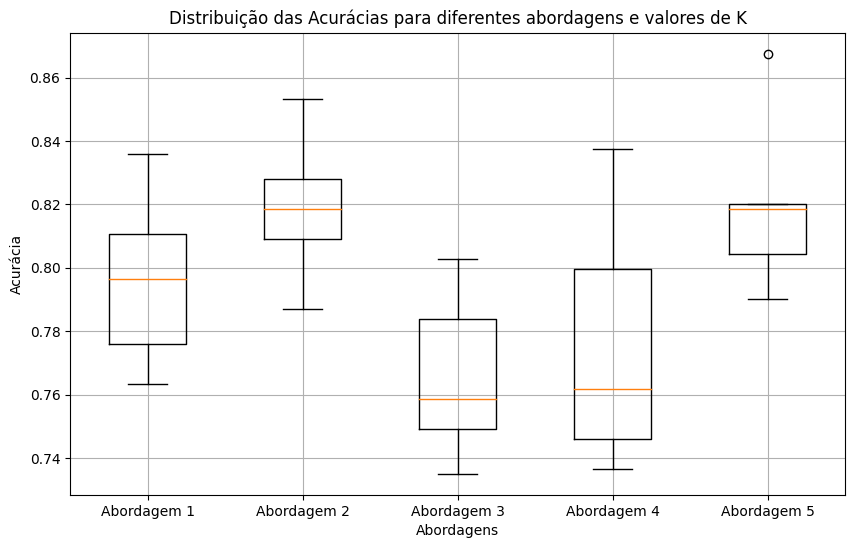

In [201]:
import matplotlib.pyplot as plt

#BOXPLOT
valores_k = [1, 3, 5, 7, 9]
abordagem1= [0.835962, 0.810726, 0.796530, 0.776025, 0.763407]
abordagem2= [0.853312, 0.828076, 0.818612, 0.809148, 0.787066]
abordagem3= [0.802839, 0.783912, 0.758675, 0.749211, 0.735016]
abordagem4= [0.837539, 0.799685, 0.761830, 0.746057, 0.736593]
abordagem5= [0.867508, 0.820189, 0.818612, 0.804416, 0.790221]

plt.figure(figsize=(10, 6))

# Criando o boxplot para cada abordagem
plt.boxplot([abordagem1, abordagem2, abordagem3, abordagem4, abordagem5],
            labels=['Abordagem 1', 'Abordagem 2', 'Abordagem 3', 'Abordagem 4', 'Abordagem 5'])

plt.xlabel('Abordagens')
plt.ylabel('Acurácia')
plt.title('Distribuição das Acurácias para diferentes abordagens e valores de K')
plt.grid(True)
plt.show()

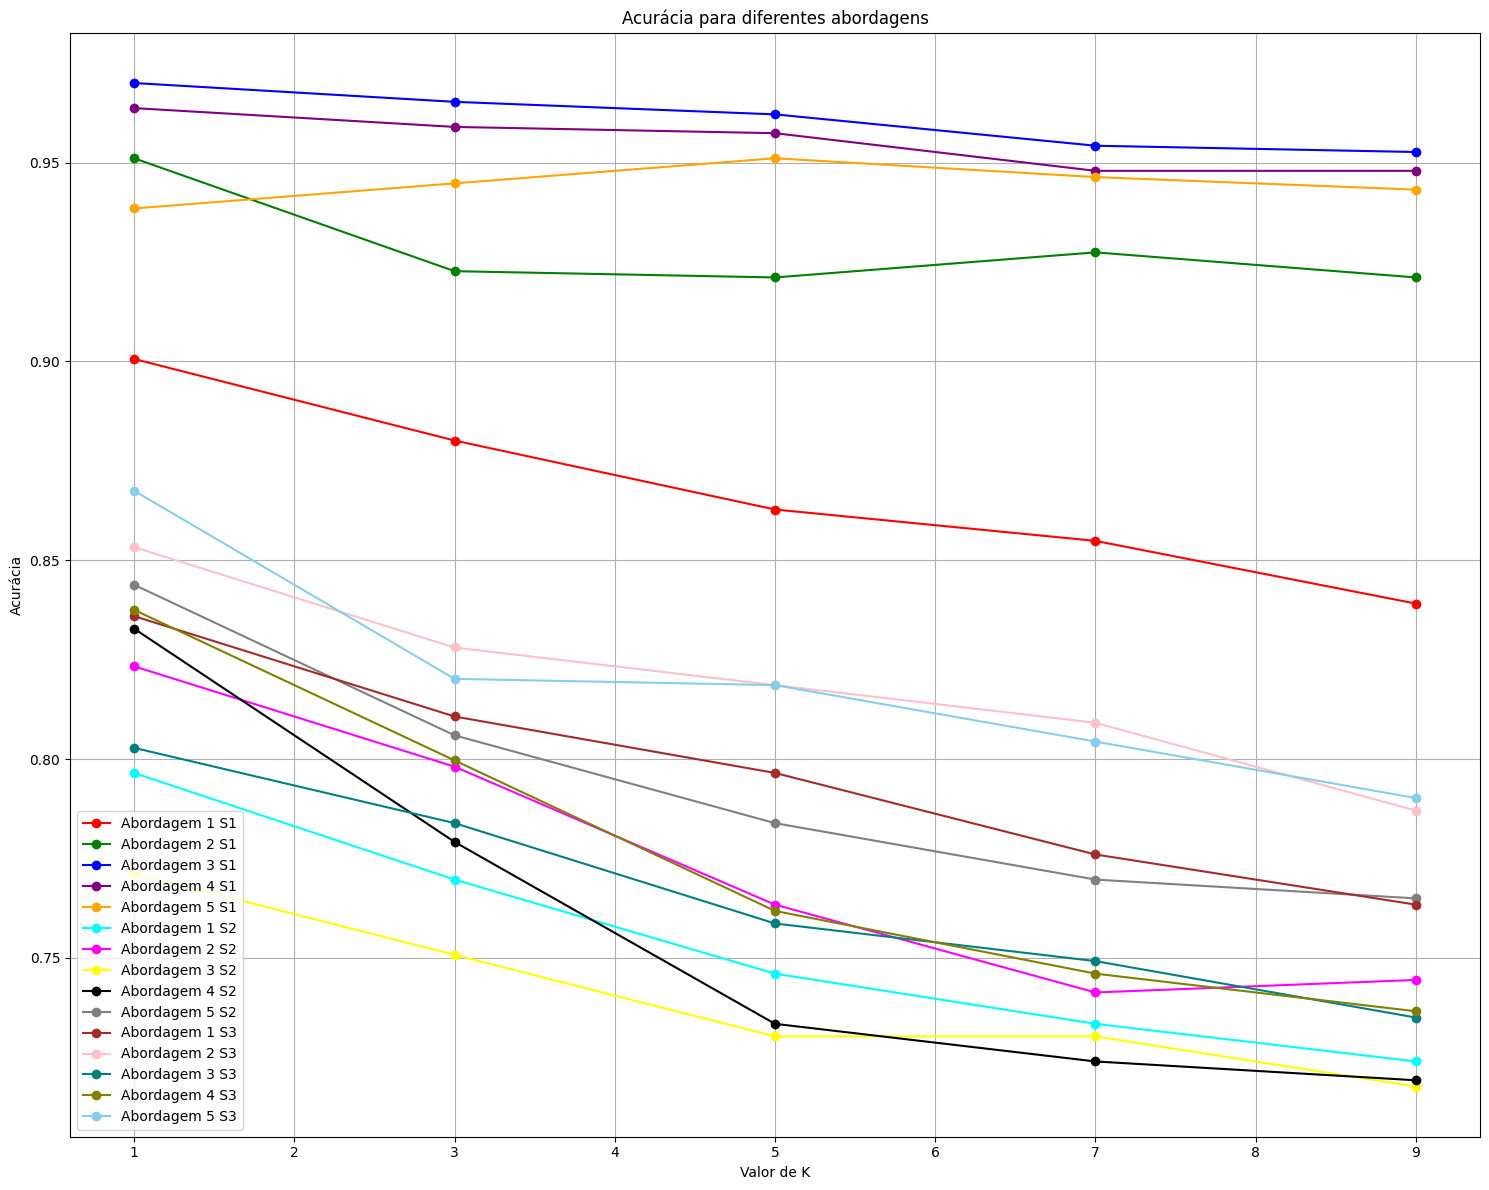

In [202]:
import matplotlib.pyplot as plt

# Dados para cada situação
valores_k = [1, 3, 5, 7, 9]

# Dados para a situação "Base não normalizada"
s1abordagem1 = [0.900631, 0.880126, 0.862776, 0.854890, 0.839117]
s1abordagem2 = [0.951104, 0.922713, 0.921136, 0.927445, 0.921136]
s1abordagem3 = [0.970032, 0.965300, 0.962145, 0.954259, 0.952681]
s1abordagem4 = [0.963722, 0.958991, 0.957413, 0.947950, 0.947950]
s1abordagem5 = [0.938486, 0.944795, 0.951104, 0.946372, 0.943218]

# Dados para a situação "Base normalizada por MinMax"
s2abordagem1 = [0.796530, 0.769716, 0.746057, 0.733438, 0.723975]
s2abordagem2 = [0.823344, 0.798107, 0.763407, 0.741325, 0.744479]
s2abordagem3 = [0.771293, 0.750789, 0.730284, 0.730284, 0.717666]
s2abordagem4 = [0.832808, 0.779180, 0.733438, 0.723975, 0.719243]
s2abordagem5 = [0.843849, 0.805994, 0.783912, 0.769716, 0.764984]

# Dados para a situação "Base normalizada por Z Score"
s3abordagem1 = [0.835962, 0.810726, 0.796530, 0.776025, 0.763407]
s3abordagem2 = [0.853312, 0.828076, 0.818612, 0.809148, 0.787066]
s3abordagem3 = [0.802839, 0.783912, 0.758675, 0.749211, 0.735016]
s3abordagem4 = [0.837539, 0.799685, 0.761830, 0.746057, 0.736593]
s3abordagem5 = [0.867508, 0.820189, 0.818612, 0.804416, 0.790221]

plt.figure(figsize=(15, 12))

# Situação 1: Base não normalizada
plt.plot(valores_k, s1abordagem1, label="Abordagem 1 S1", color='red',  marker='o')
plt.plot(valores_k, s1abordagem2, label="Abordagem 2 S1", color='green', marker='o')
plt.plot(valores_k, s1abordagem3, label="Abordagem 3 S1", color='blue', marker='o')
plt.plot(valores_k, s1abordagem4, label="Abordagem 4 S1", color='purple', marker='o')
plt.plot(valores_k, s1abordagem5, label="Abordagem 5 S1", color='orange', marker='o')
# Situação 2: Base normalizada por MinMax
plt.plot(valores_k, s2abordagem1, label="Abordagem 1 S2", color='cyan', marker='o')
plt.plot(valores_k, s2abordagem2, label="Abordagem 2 S2", color='magenta', marker='o')
plt.plot(valores_k, s2abordagem3, label="Abordagem 3 S2", color='yellow', marker='o')
plt.plot(valores_k, s2abordagem4, label="Abordagem 4 S2", color='black', marker='o')
plt.plot(valores_k, s2abordagem5, label="Abordagem 5 S2", color='gray', marker='o')
# Situação 3: Base normalizada por Z Score
plt.plot(valores_k, s3abordagem1, label="Abordagem 1 S3", color='brown', marker='o')
plt.plot(valores_k, s3abordagem2, label="Abordagem 2 S3", color='pink', marker='o')
plt.plot(valores_k, s3abordagem3, label="Abordagem 3 S3", color='teal', marker='o')
plt.plot(valores_k, s3abordagem4, label="Abordagem 4 S3", color='olive', marker='o')
plt.plot(valores_k, s3abordagem5, label="Abordagem 5 S3", color='skyblue', marker='o')
plt.title('Acurácia para diferentes abordagens')
plt.grid(True)
plt.legend()

plt.xlabel('Valor de K')
plt.ylabel('Acurácia')

plt.tight_layout()
plt.show()
